In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, warnings
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn import preprocessing

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from plots import Plots
plot = Plots()

2022-07-02 21:26:11,127 — FileHandler — DEBUG — Loaded successfully!
2022-07-02 21:26:11,781 — Plot — DEBUG — Loaded successfully!


In [7]:
file_handler = FileHandler()
data_df = file_handler.read_csv("../data/cleaned_data.csv") 

2022-07-02 21:28:14,557 — FileHandler — DEBUG — file read as csv


In [8]:
data_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Select Training Features and Target Variable

In [15]:
# Y includes our target and X includes our features

features = data_df.drop(['diagnosis'], axis=1)
X = file_handler.scale_and_normalize(features) 

target = data_df.diagnosis # M or B
Y = target.map(lambda x: 1 if x == "M" else  0)

## Feature Selection

31 features make up our input data, which is too many for causal inference modeling. Using correlation, univariant feature selection, and the Random Forest Classifier Feature Importance library, we will attempt to choose only ten features. By fitting the data to the RandomForestClassifier, we will assess the feature selection in each of the three scenarios.

### 1. Correlation-based Feature Selection
As we discussed on the EDA analysis, we have a number of correlation between our features. Therefore we can take only the top 10 highly correlated features and neglect the remaining ones.  

Text(0.5, 1.0, 'Correlation Between Features')

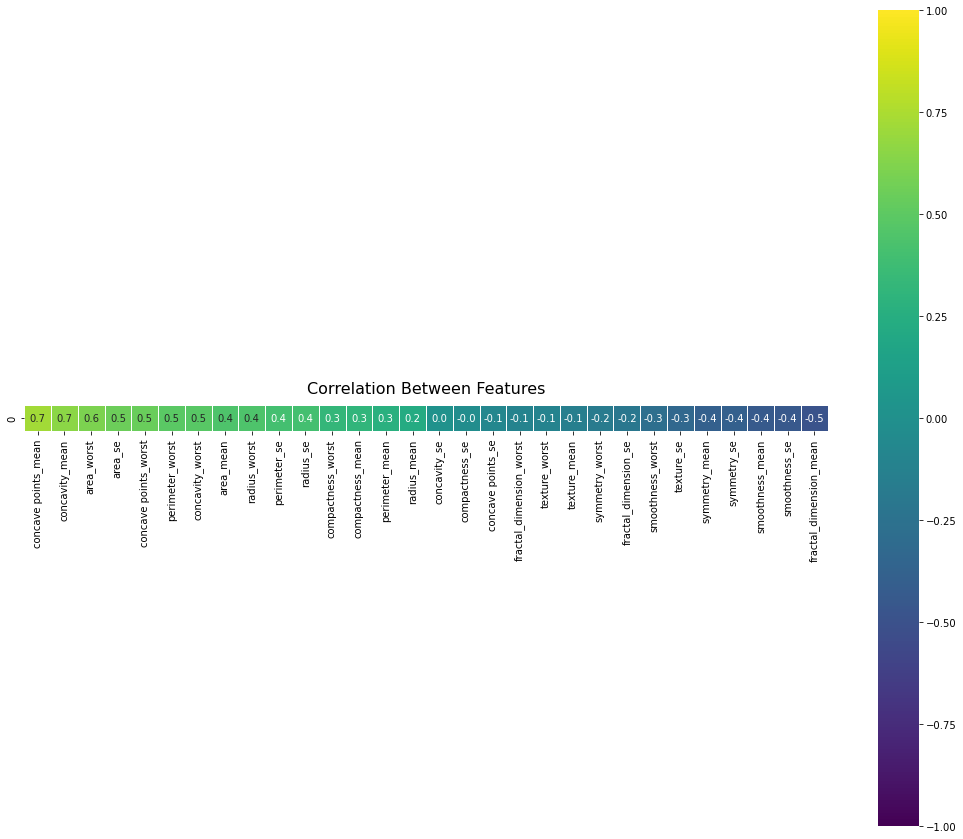

In [13]:
corr_df = pd.DataFrame(X.corrwith(Y)).sort_values(by=0, ascending=False)
corr_df.rename({0: "diagnosis"}, axis=1)
corr = corr_df.T
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(18, 15))
heatmap = sns.heatmap(corr, square=True, linewidths=.5,
                      vmin=-1, vmax=1, cmap='viridis', annot=True, fmt='.1f')
heatmap.set_title('Correlation Between Features',
                  fontdict={'fontsize': 16}, pad=12)

Now let's check the top 10 highly correlated features with `diagnosis` column.

In [14]:
corr_df.head(10)

,0
concave points_mean,0.720343
concavity_mean,0.651661
area_worst,0.602967
area_se,0.549069
concave points_worst,0.545949
perimeter_worst,0.488104
concavity_worst,0.479342
area_mean,0.443901
radius_worst,0.441910
perimeter_se,0.406138


In [18]:
top_10_features = ['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 
                    'radius_mean', 'area_mean', 'concavity_mean',  'concavity_worst']
X_corr = X[top_10_features]

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Accuracy is:  0.9415204678362573


<AxesSubplot:>

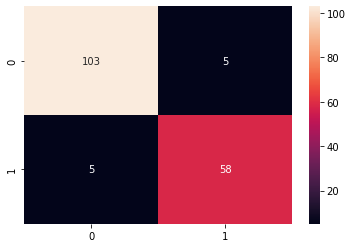

In [19]:
#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

The accuracy of this correlation based feature selection techniques is 94% with a few wrong predictions.

### 2. Univariate Feature Selection

In this technique the sklearn SelectKBest feature selection library that select features according to the k highest scores will be used.
In this method we need to choose how many features we want to select. I used k=10, which is also a default k value, where top 10 features will be selected.

In [20]:
X = data_df.drop(columns = ['diagnosis'], axis=1)
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# find best scored 10 features
select_feature = SelectKBest(chi2, k=10).fit(x_train, y_train)

In [22]:
print('Score list:\n', select_feature.scores_)
print('\nFeature list:\n', x_train.columns)

Score list:
 [1.77946492e+02 6.06916433e+01 1.34061092e+03 3.66899557e+04
 1.00015175e-01 3.41839493e+00 1.30547650e+01 7.09766457e+00
 1.95982847e-01 3.42575072e-04 2.45882967e+01 4.07131026e-02
 1.72696840e+02 6.12741067e+03 1.32470372e-03 3.74071521e-01
 6.92896719e-01 2.01587194e-01 1.39557806e-03 2.65927071e-03
 3.25782599e+02 1.16958562e+02 2.40512835e+03 7.50217341e+04
 2.63226314e-01 1.19077581e+01 2.58858117e+01 8.90751003e+00
 1.00635138e+00 1.23087347e-01]

Feature list:
 Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst',

In [23]:
score_list = list(select_feature.scores_)
feature_list = x_train.columns

In [24]:
# Create a dictionary which links the feature_list and score_list
feature_dict = {}
for key in feature_list:
    for value in score_list:
        feature_dict[key] = value
        score_list.remove(value)
        break  

In [25]:
# Select the top 10 features

from heapq import nlargest
top_10_features = nlargest(10, feature_dict, key=feature_dict.get)
print("Top ten features: \n",top_10_features) 

Top ten features: 
 ['area_worst', 'area_mean', 'area_se', 'perimeter_worst', 'perimeter_mean', 'radius_worst', 'radius_mean', 'perimeter_se', 'texture_worst', 'texture_mean']


Accuracy is:  0.9590643274853801


<AxesSubplot:>

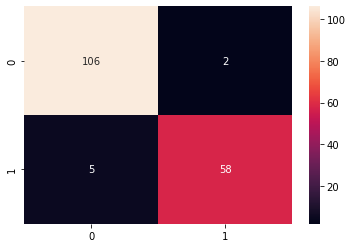

In [26]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)

# RandomForestClassifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

This feature selection's accuracy is 95%, which is better than the previous technique.

### 3. Feature Selection using Random Forest Classifier Feature Importance

The Random Forest algorithm has built-in feature importance selection method to find only the important features. Features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gain.

In [29]:

clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 27 (0.156347)
2. feature 20 (0.136515)
3. feature 22 (0.130859)
4. feature 7 (0.098465)
5. feature 23 (0.076843)
6. feature 6 (0.058250)
7. feature 2 (0.048293)
8. feature 3 (0.039279)
9. feature 26 (0.028223)
10. feature 25 (0.025346)
11. feature 0 (0.025068)
12. feature 13 (0.022273)
13. feature 21 (0.017068)
14. feature 1 (0.015725)
15. feature 24 (0.015014)
16. feature 28 (0.013346)
17. feature 12 (0.012065)
18. feature 17 (0.010761)
19. feature 18 (0.009517)
20. feature 10 (0.009355)
21. feature 16 (0.008550)
22. feature 4 (0.007181)
23. feature 5 (0.005327)
24. feature 19 (0.005230)
25. feature 15 (0.004817)
26. feature 8 (0.004813)
27. feature 14 (0.004470)
28. feature 29 (0.003973)
29. feature 11 (0.003613)
30. feature 9 (0.003415)


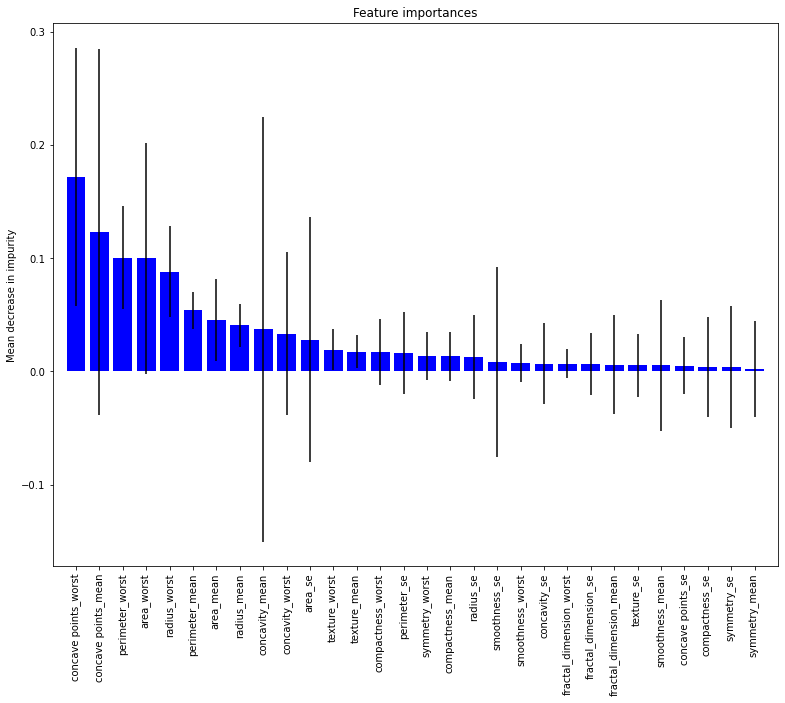

In [28]:
# Plot the feature importances of the forest

plt.figure(1, figsize=(13, 10))
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

From this feature selection method, we have got the following top 10 features:
`perimeter_worst`, `concave points_worst`, `concave points_mean`, `area_worst`, `radius_worst`, `perimeter_mean`, 
            `concavity_mean`, `concavity_worst`, `area_mean`, and `area_se`. 
Let`s check the feature performance using random forest classifier. 

Accuracy is:  0.9590643274853801


<AxesSubplot:>

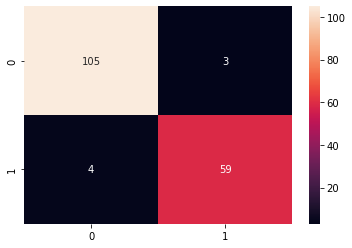

In [30]:
columns = ['perimeter_worst', 'concave points_worst', 'concave points_mean', 'area_worst', 'radius_worst', 'perimeter_mean', 
            'concavity_mean', 'concavity_worst', 'area_mean', 'area_se']

X = data_df[columns]
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

Using this strategy, we achieved a 95.9% feature importance selection accuracy. This feature selection method and the prior univariant method both produce results that are nearly similar. When I used a 30% testing set, they provided 95.9% accuracy, which is precisely the same. While trying them with 40% testing set, the univariant method exceeds with a very small amount. Because of this, we can choose one of them for our causal inference modeling.

### Conclusion

The given dataset comprises 31 features, but we were able to minimize this number to 10 with a 95 percent accuracy rate after applying the above feature selection techniques.

### Save the selected feature data
The features selected by the the bivariant method is going to be saved for our causal modeling.

In [59]:
columns = ['area_worst', 'area_mean', 'area_se', 'perimeter_worst', 'perimeter_mean', 
        'radius_worst', 'radius_mean', 'perimeter_se', 'texture_worst', 'texture_mean']
feature_df = data_df[columns]
feature_df.insert(loc=0, column='diagnosis', value=Y)
file_handler.save_csv(feature_df, "../data/features_data.csv") 

2022-07-01 23:31:48,438 — FileHandler — INFO — file saved as csv
